## Imports

In [5]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
from pathlib import Path

# Add the src/ directory to sys.path
sys.path.append(str(Path().resolve().parent / 'src'))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from andy.category import (
    AddressTransformer,
    CategoricalTransformer,
    JobTitleTransformer,
    OrdinalTransformer,
    PurposeTransformer,
)
from andy.datetime import DatetimeTransformer
from andy.params import (
    EMP_LENGTH_RANKS,
    HOME_OWNERSHIP_RANKS,
    VERIFICATION_STATUS_RANKS,
)

In [7]:
sns.set_theme(style="darkgrid")

## Data Load

In [8]:
train = pd.read_csv('/Users/khl/Desktop/train.csv', index_col=0)
test = pd.read_csv('/Users/khl/Desktop/train.csv', index_col=0)

## General Data View

In [9]:
# print("Dataset shape:", train.shape)
# print("\nMissing values:\n", train.isnull().sum())
# print("\nData types:\n", train.info())

# print("\nSummary statistics:")
# print(train.describe())

## 1D Distributions

### Label Distributions

Text(0.5, 1.0, 'Distribution of Loan Status')

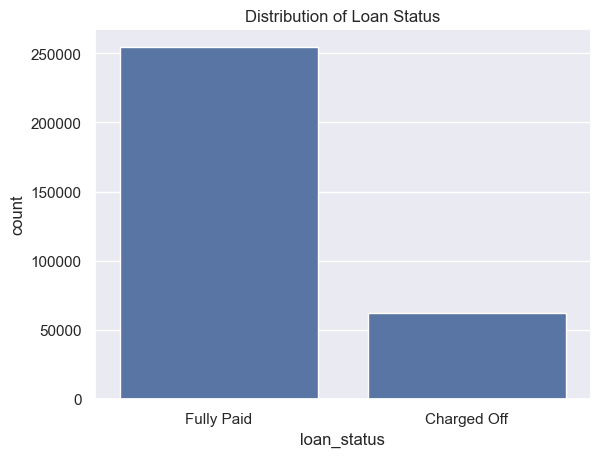

In [ ]:
# print("Loan Status Distribution:")
# print(train["loan_status"].value_counts(normalize=True) * 100)

sns.countplot(data=train, x="loan_status")
plt.title("Distribution of Loan Status")

# 20% is seems like a very high delinquency rate in the Fintech Industry; how are they staying afloat?

### Numerical Columns

Text(0.5, 1.0, 'Outliers in Numerical Features')

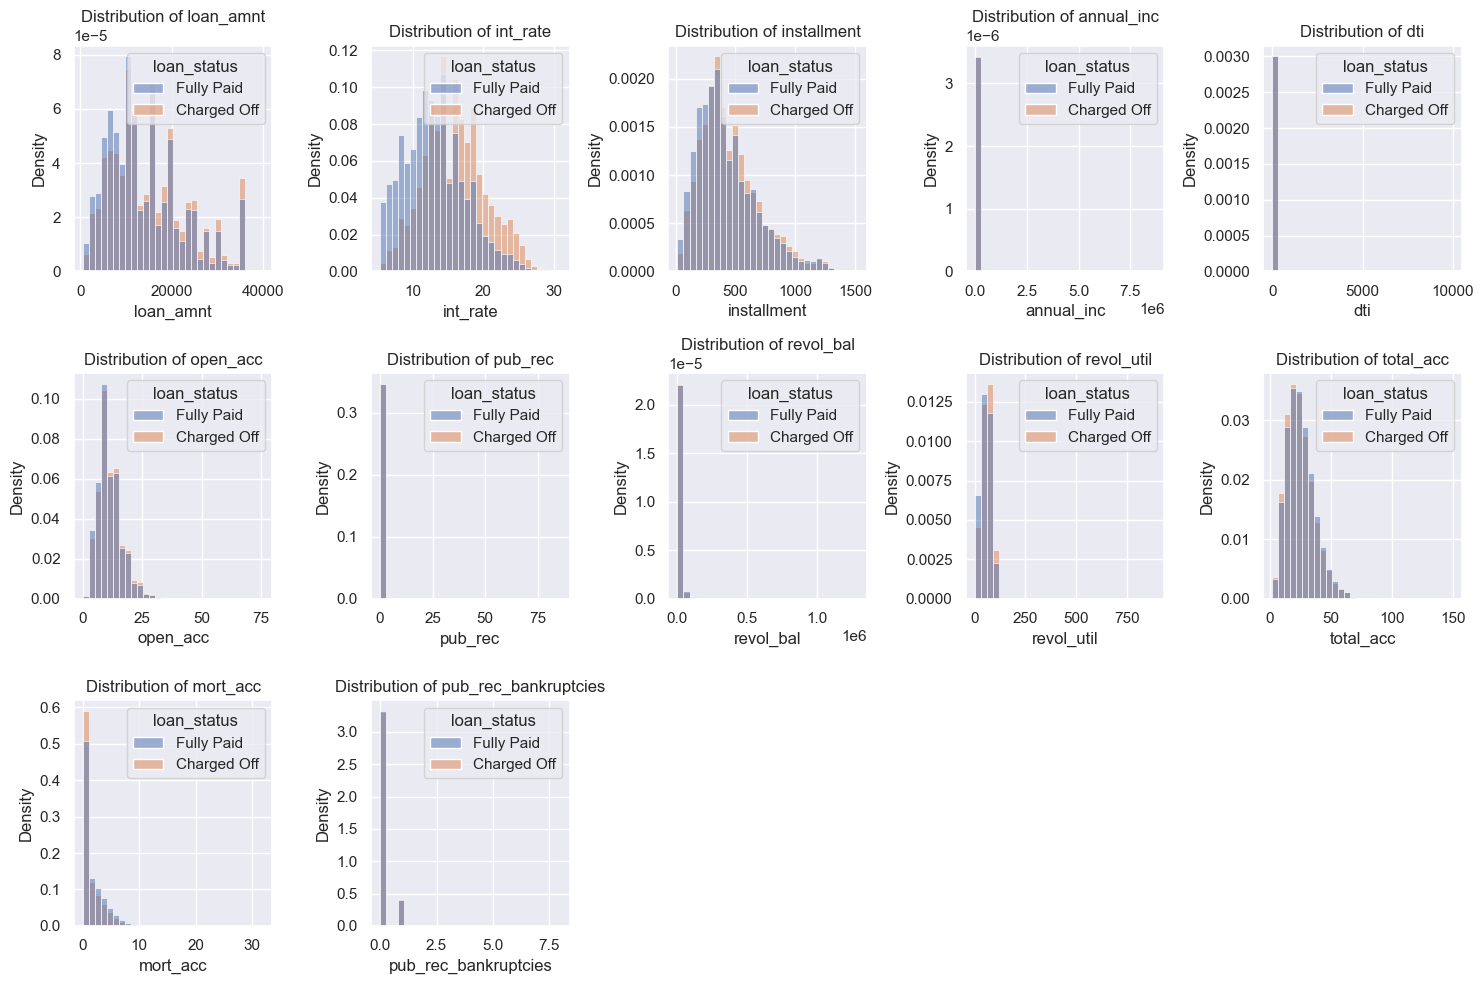

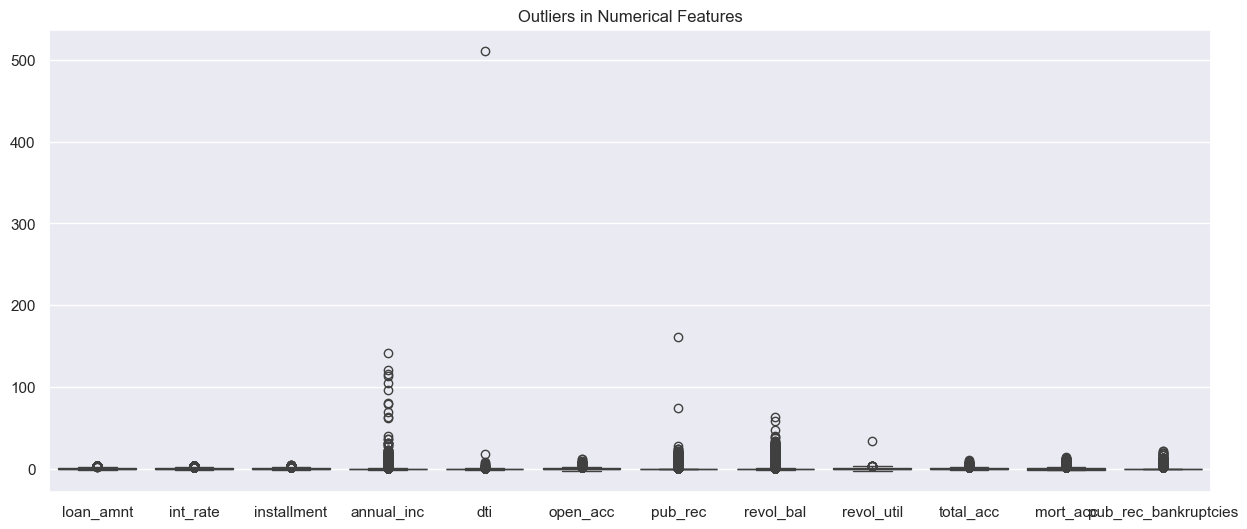

In [11]:
numerical_cols = train.select_dtypes(include=["number"]).columns
# print(train[numerical_cols].describe())

# distribution
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, len(numerical_cols) // 3 + 1, i)
    sns.histplot(
        data=train, hue="loan_status", x=col, bins=30, stat="density", common_norm=False
    )
    plt.title(f"Distribution of {col}")
plt.tight_layout()

# outliers
plt.figure(figsize=(15, 6))

# these should all be normalized to the same scale
# so we can use a boxplot to check for outliers and the distribution of the data
scaler = StandardScaler()
numerical_data = scaler.fit_transform(train[numerical_cols])
numerical_data = pd.DataFrame(numerical_data, columns=numerical_cols)
sns.boxplot(data=numerical_data)
plt.title("Outliers in Numerical Features")

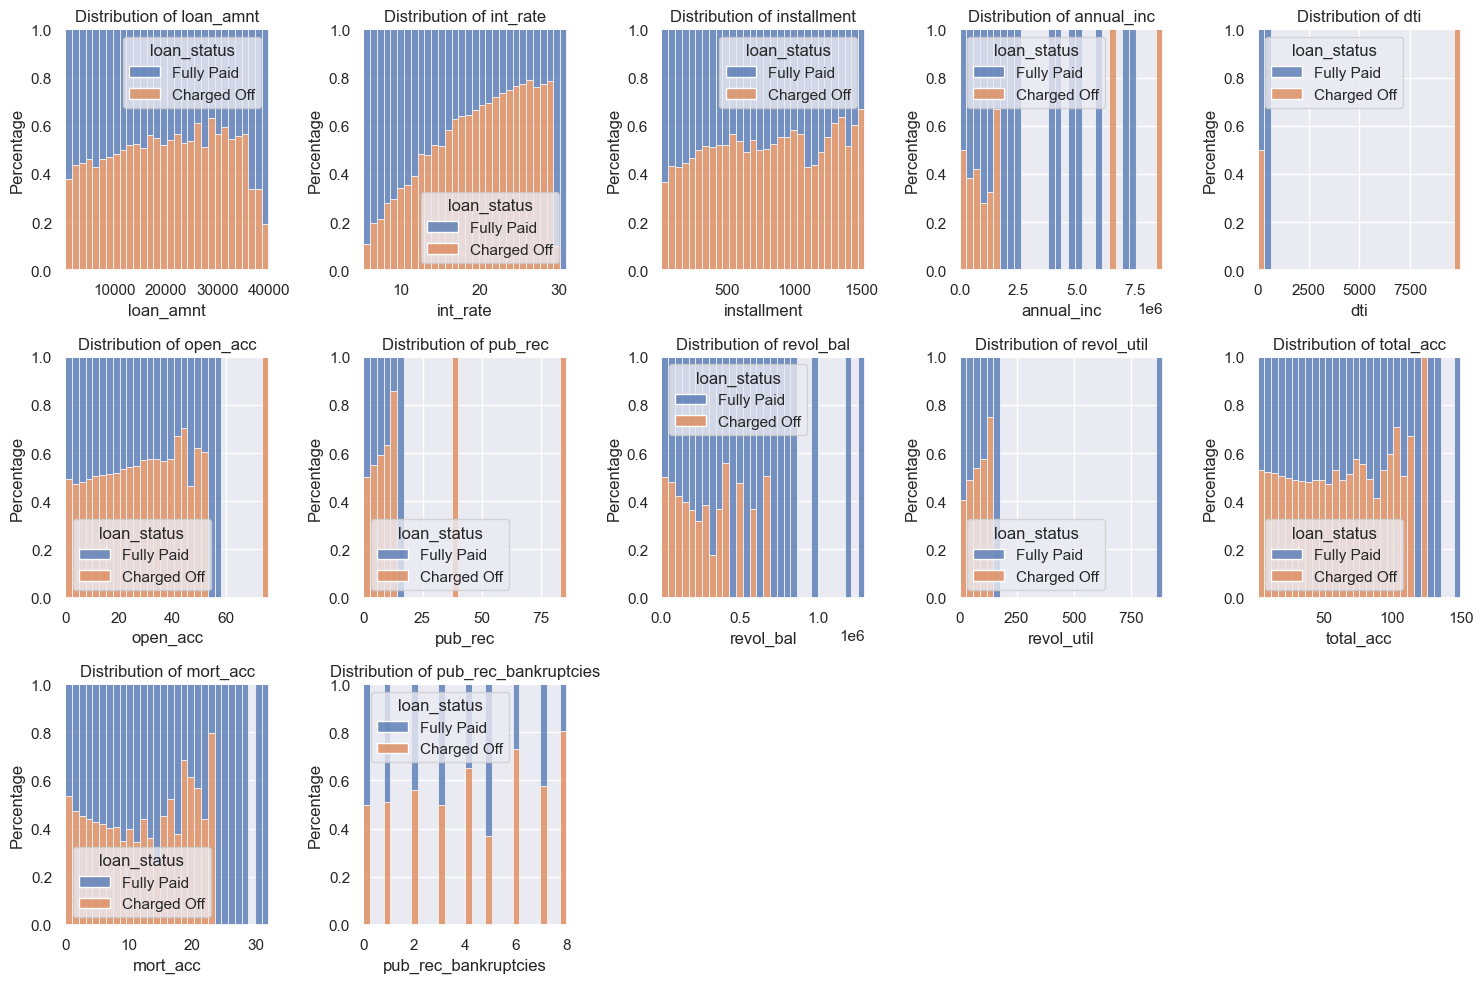

In [12]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, len(numerical_cols) // 3 + 1, i)

    # Plot histogram with percentages
    sns.histplot(
        data=train,
        x=col,
        hue="loan_status",
        bins=30,
        stat="percent",  # Show percentages instead of density
        common_norm=False,  # Normalize within each loan status
        multiple="fill",  # Stack to show proportions
    )

    plt.title(f"Distribution of {col}")
    plt.ylabel("Percentage")

plt.tight_layout()
plt.show()

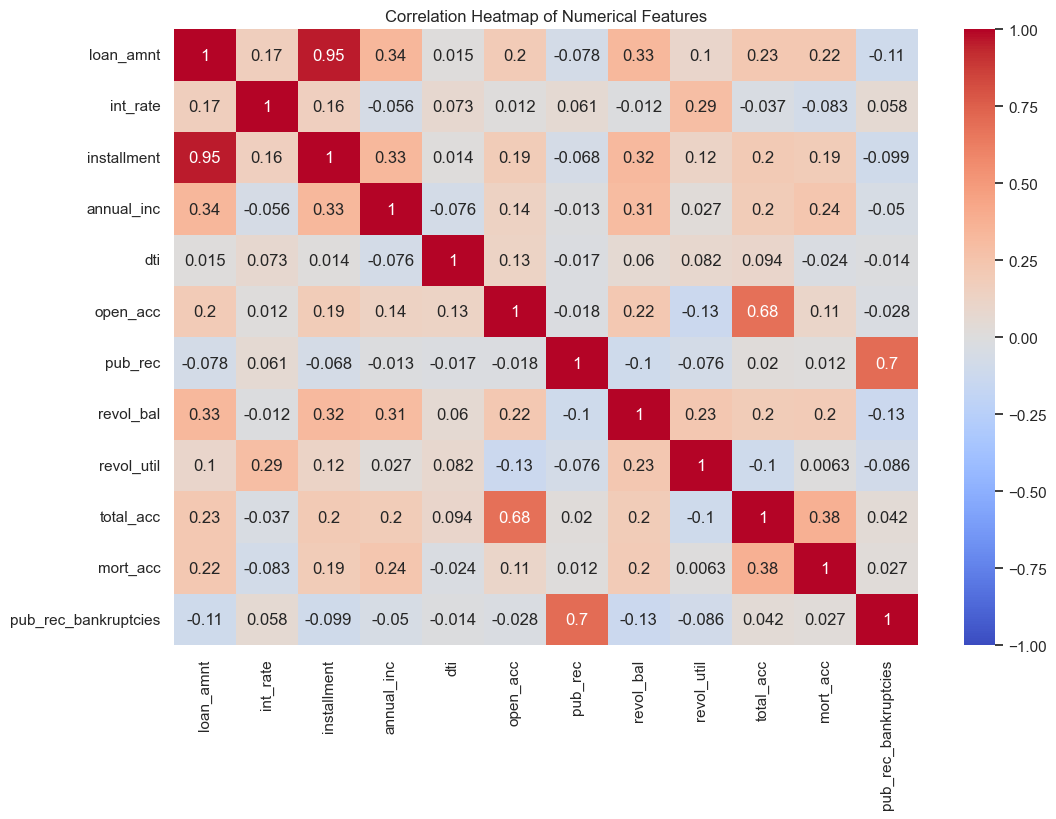

In [13]:
# check columns that are super correlated
corr_matrix = numerical_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### Datetime Columns

/Users/khl/andrew-assessment/src/andy/datetime.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X[col] = pd.to_datetime(X[col], format=self.format)
/Users/khl/andrew-assessment/src/andy/datetime.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  X[col] = pd.to_datetime(X[col], format=self.format)


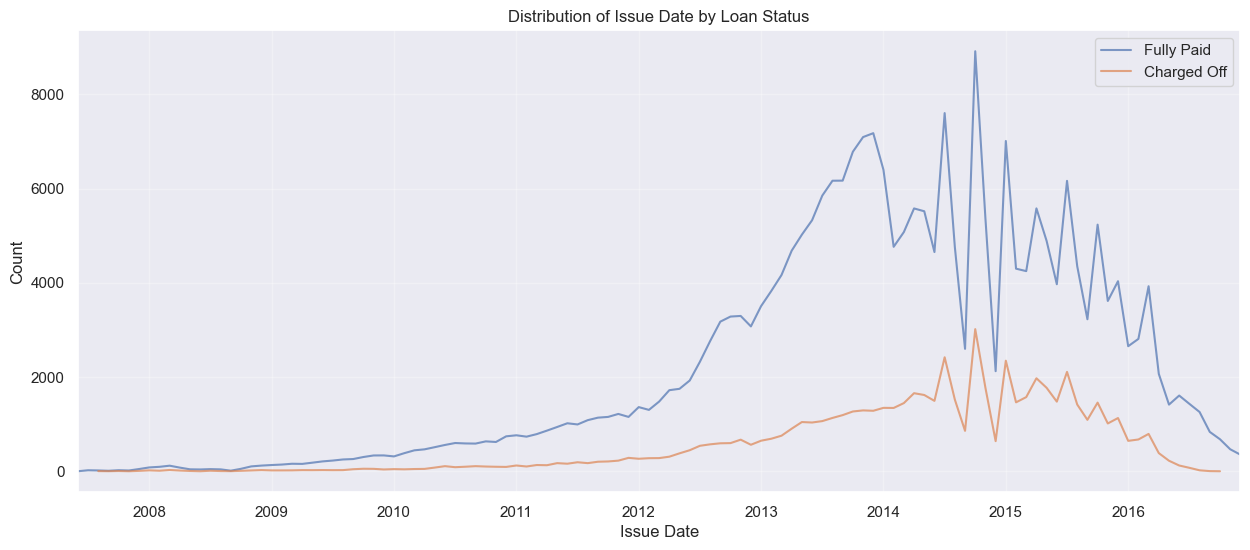

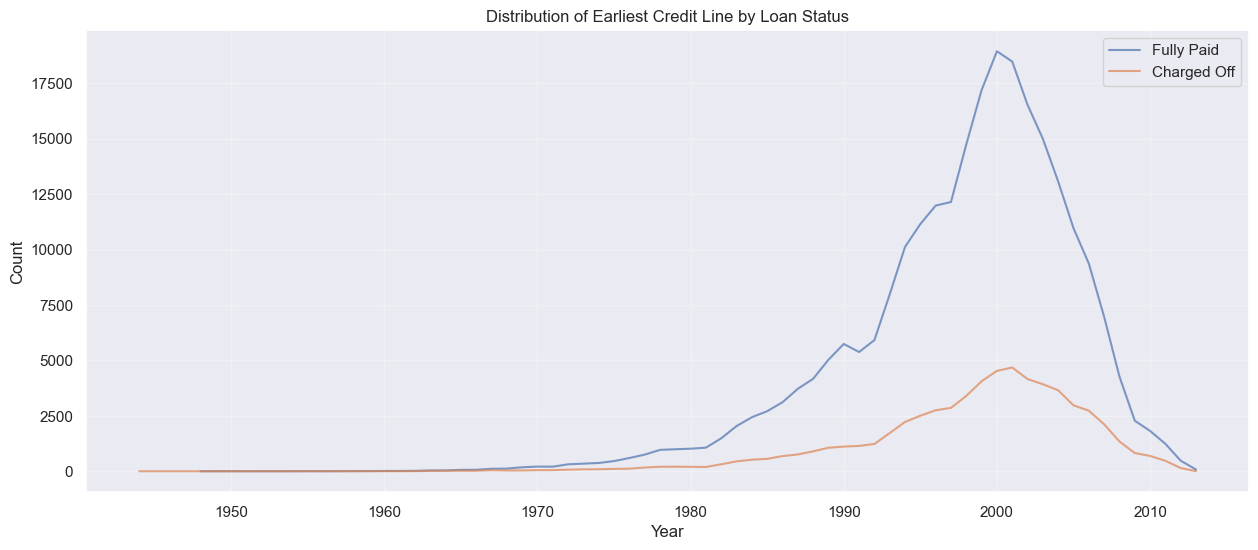

In [14]:
# issue_d and earliest_cr_line are datetime columns
# let's convert them to datetime
train = DatetimeTransformer(
    datetime_cols=["issue_d", "earliest_cr_line"]
).fit_transform(train)

# let's see the distribution of the datetime columns
plt.figure(figsize=(15, 6))

# Plot for each loan status
for status in train["loan_status"].unique():
    mask = train["loan_status"] == status
    (
        train[mask]["issue_d"]
        .value_counts()
        .sort_index()
        .plot(kind="line", label=status, alpha=0.7)
    )

plt.title("Distribution of Issue Date by Loan Status")
plt.xlabel("Issue Date")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Same for earliest credit line
plt.figure(figsize=(15, 6))

for status in train["loan_status"].unique():
    mask = train["loan_status"] == status
    (
        train[mask]["earliest_cr_line"]
        .dt.year.value_counts()
        .sort_index()
        .plot(kind="line", label=status, alpha=0.7)
    )

plt.title("Distribution of Earliest Credit Line by Loan Status")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<Figure size 1500x600 with 0 Axes>

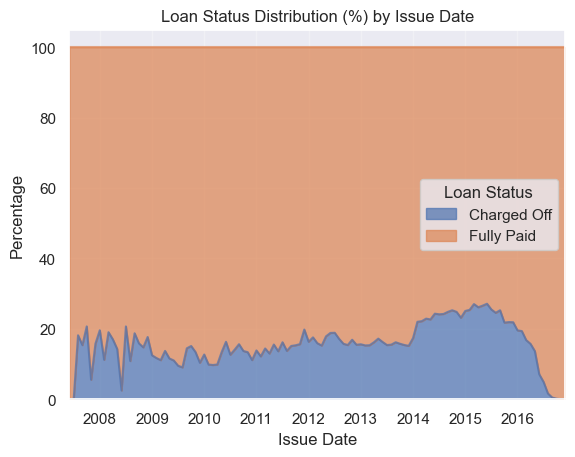

<Figure size 1500x600 with 0 Axes>

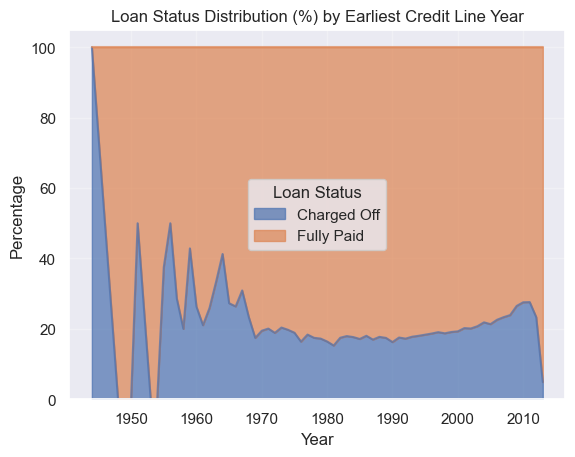

In [15]:
# For issue date (monthly)
plt.figure(figsize=(15, 6))

# Calculate percentages using crosstab
monthly_ratios = (
    pd.crosstab(train["issue_d"], train["loan_status"], normalize="index") * 100
)

# Plot stacked percentage
monthly_ratios.plot(kind="area", stacked=True, alpha=0.7)

plt.title("Loan Status Distribution (%) by Issue Date")
plt.xlabel("Issue Date")
plt.ylabel("Percentage")
plt.legend(title="Loan Status")
plt.grid(True, alpha=0.3)
plt.show()

# For earliest credit line (yearly)
plt.figure(figsize=(15, 6))

# Calculate percentages using crosstab
yearly_ratios = (
    pd.crosstab(
        train["earliest_cr_line"].dt.year, train["loan_status"], normalize="index"
    )
    * 100
)

# Plot stacked percentage
yearly_ratios.plot(kind="area", stacked=True, alpha=0.7)

plt.title("Loan Status Distribution (%) by Earliest Credit Line Year")
plt.xlabel("Year")
plt.ylabel("Percentage")
plt.legend(title="Loan Status")
plt.grid(True, alpha=0.3)
plt.show()

### Categorical Columns

In [16]:
categorical_cols = train.select_dtypes(include=["object"]).columns.tolist()

# see how many unique values there are in each categorical column
# for col in categorical_cols:
#     print(f"{col}: {train[col].nunique()}")

# convert low cardinality columns to categorical
train = CategoricalTransformer(
    categorical_cols=categorical_cols, cutoff=35
).fit_transform(train)

In [17]:
# check for ordinal columns
# for col in train.select_dtypes(include=["category"]).columns:
#     print(f"{col}: {train[col].value_counts().head(5)}")

ordinal_mappings = {
    "term": sorted(train["term"].unique()),
    "grade": sorted(train["grade"].unique()),
    "sub_grade": sorted(train["sub_grade"].unique()),
    "emp_length": EMP_LENGTH_RANKS,
    "home_ownership": HOME_OWNERSHIP_RANKS,
    "verification_status": VERIFICATION_STATUS_RANKS,
}


ordinal_transformer = OrdinalTransformer(ordinal_mappings)
train = ordinal_transformer.fit_transform(train)

In [18]:
# high cardinality columns
high_cardinality_cols = [col for col in categorical_cols if train[col].nunique() > 35]

# let's see the most common values
# for col in high_cardinality_cols:
#     print(
#         f"{col}: {train[col].nunique()}\n{train[col].value_counts(sort=True).head(10)}\n"
#     )

In [19]:
train = AddressTransformer().fit_transform(train)

In [20]:
job_transformer = JobTitleTransformer(
    job_map=JOB_MAP, n_common_titles=30, similarity_threshold=0.6
)
train = job_transformer.fit_transform(train)

Binning job titles: 100%|██████████| 316970/316970 [00:02<00:00, 130052.94it/s]


In [21]:
# print(train[["purpose", "title"]].sample(10))

# looks like purpose and title are the same thing
purpose_transformer = PurposeTransformer()
train = purpose_transformer.fit_transform(train)

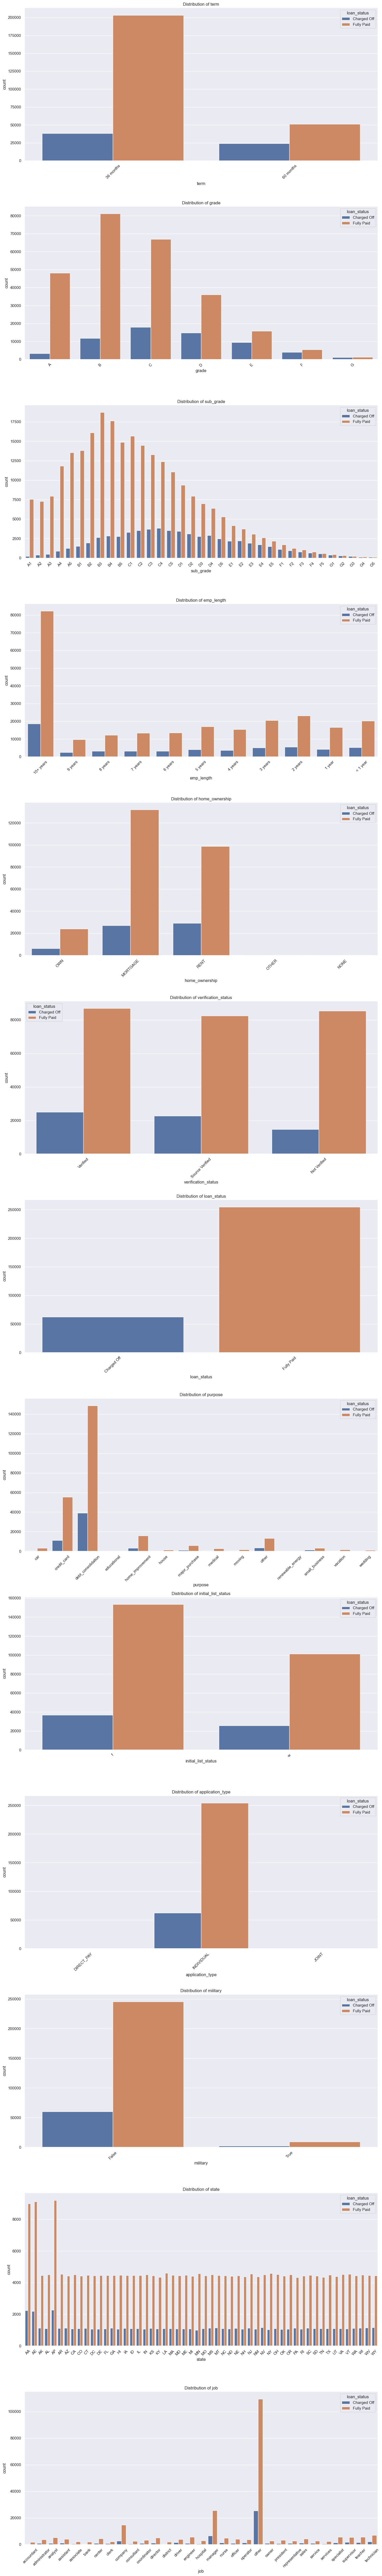

In [22]:
categorical_cols = train.select_dtypes(include=["category"]).columns

plt.figure(figsize=(15, 100))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(13, 1, i)
    sns.countplot(data=train, x=col, hue="loan_status")
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

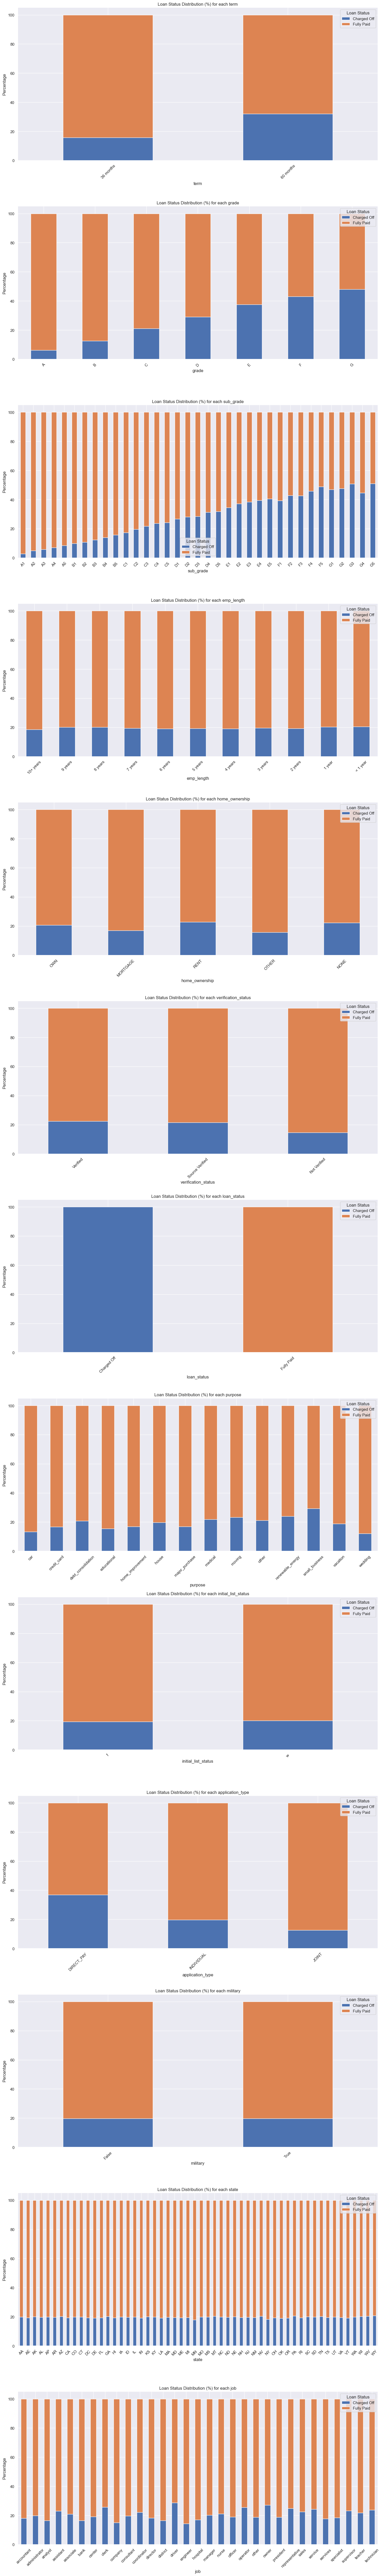

In [23]:
plt.figure(figsize=(15, 100))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(13, 1, i)

    # Calculate percentages using crosstab
    ratios = pd.crosstab(train[col], train["loan_status"], normalize="index") * 100

    # Plot stacked bars
    ratios.plot(kind="bar", stacked=True, ax=plt.gca())

    plt.title(f"Loan Status Distribution (%) for each {col}")
    plt.xlabel(col)
    plt.ylabel("Percentage")
    plt.xticks(rotation=45)
    plt.legend(title="Loan Status")

plt.tight_layout()
plt.show()

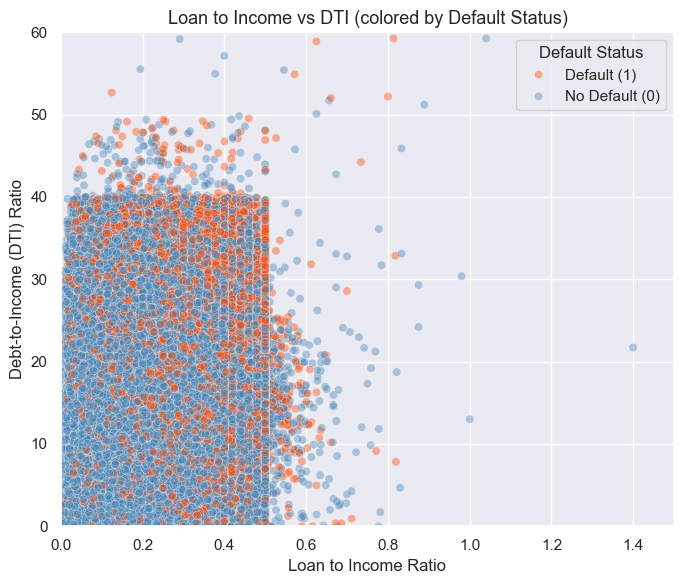

In [65]:
# Scatter plot: loan_to_income vs dti
# as loan-to-income increases beyond ~ 0.4, the share of defaults increases dramatically

# how much of the borrower's income the loan amt. represnts
train['loan_to_income'] = train['loan_amnt'] / train['annual_inc']

# 1 if loan_status is charged off, else 0
train['is_default'] = train['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)

# 2D Scatter Plot: loan_to_income vs dti
plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=train,
    x='loan_to_income',
    y='dti',
    hue='is_default',
    palette={0: 'steelblue', 1: 'orangered'},
    alpha=0.4
)

# Focus on main cluster region for visibility
plt.xlim(0, 1.5)
plt.ylim(0, 60)

plt.title('Loan to Income vs DTI (colored by Default Status)', fontsize=13)
plt.xlabel('Loan to Income Ratio')
plt.ylabel('Debt-to-Income (DTI) Ratio')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Default (1)', 'No Default (0)'], title='Default Status')
plt.grid(True)
plt.tight_layout()
plt.show()

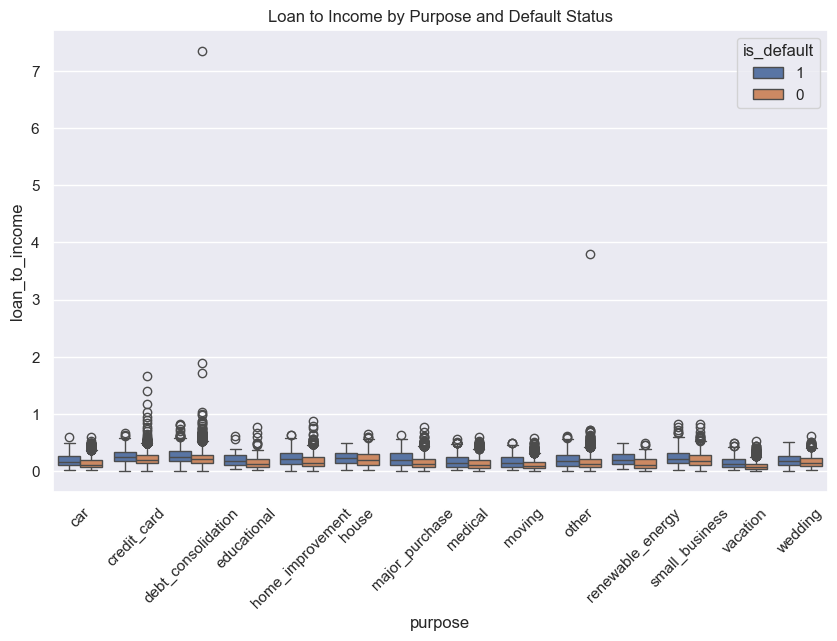

In [25]:
# Boxplot: purpose vs loan_to_income
plt.figure(figsize=(10, 6))
sns.boxplot(data=train, x='purpose', y='loan_to_income', hue='is_default')
plt.title('Loan to Income by Purpose and Default Status')
plt.xticks(rotation=45)
plt.show()

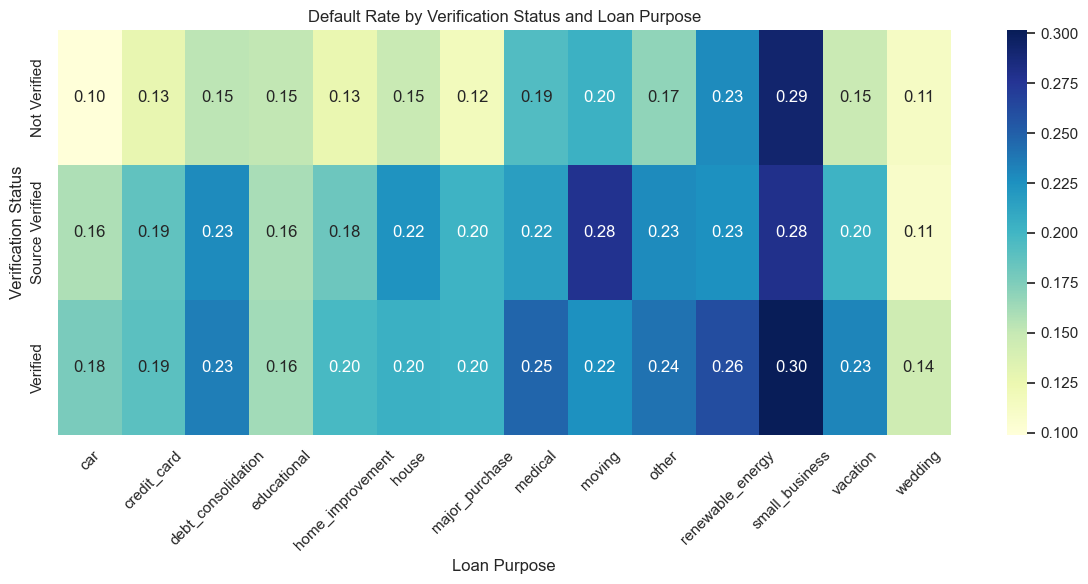

In [27]:
# Make sure all groupers are not categorical
df = train.copy()
df["verification_status"] = df["verification_status"].astype(str)
df["purpose"] = df["purpose"].astype(str)
df["is_default"] = pd.to_numeric(df["is_default"], errors="coerce")  # ensure it's numeric

# Now compute the crosstab
ct = pd.crosstab(index=df['verification_status'],
                 columns=df['purpose'],
                 values=df['is_default'],
                 aggfunc='mean').fillna(0)

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(ct, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Default Rate by Verification Status and Loan Purpose")
plt.ylabel("Verification Status")
plt.xlabel("Loan Purpose")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Saving the train dataset that I've been working on for thie file
import os

# Get full path to "data" directory relative to project root
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go up one level
data_dir = os.path.join(base_dir, "data")
os.makedirs(data_dir, exist_ok=True)

# Save file
file_path = os.path.join(data_dir, "train_cleaned.parquet")
train.to_parquet(file_path, index=False)